<a href="https://colab.research.google.com/github/matteonerini/pin-side-channel-attacks/blob/main/PIN_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Digit Classification with SVM, RF, k-NN, and MLP

## Data Pre-processing

The dataset is uploaded from a .txt file and pre-processed.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

short = True
url = 'https://raw.githubusercontent.com/matteonerini/pin-side-channel-attacks/main/dataset.txt'

names = ['Digit','Acc_X','Acc_Y','Acc_Z','Gir_X','Gir_Y','Gir_Z','Gra_X','Gra_Y','Gra_Z',
         'Lin_X','Lin_Y','Lin_Z','Rot_Z','Ori_X','Ori_Y','M']

dataset = pd.read_csv(url, names=names).values

n_class = 10
n_entries, n_feat = dataset.shape
n_feat = n_feat -1
test_size = 0.1 if short else 0.05
n_test_digit = int(n_entries*test_size/n_class)

X = dataset[:,1:17]
y = dataset[:,0]

# Feature scaling
scaler=StandardScaler()
X_scaled = scaler.fit_transform(X)

## Model Generation, Training and Testing

The dataset is randomly divided in train and test sets. The model is generated, trained and tested with different seeds.

In [ ]:
from datetime import datetime
import csv
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
import heapq
from itertools import combinations
import scipy.special

model = 'rf' # 'svm', 'rf', 'knn', or 'mlp'
divType = 'prod' # 'prod' for {'svm','rf','mlp'}, or 'sum' for 'knn'
n_div = 10
n_seeds = 20

In the following cell, the diversity is implemented as follows:

1. The probabilities are calculated for each class.
2. The $d$ probabilities obtained for each class are multiplied/summed up, depending on the variable `divType`.
3. The class with the gratest product/sum is selected.

In [ ]:
csvFileName = "./" + model + '-' + divType + '.csv'

# Precompute all the combinations with iDiv items and the combination indexes
comb_list_all = []
iComb_list_all = []
for div in range(2,n_div+1):
    comb_list_all.append(list(combinations(range(0,n_test_digit), div)))
    iComb_list_all.append(np.array(range(int(scipy.special.binom(n_test_digit, div)))))

for seed in range(n_seeds):

    # Split into train test sets with seeds from 1 to n_seeds
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_size, random_state=seed+1, stratify=y)
    
    if model == 'svm':
        # SVM
        print('Model: ' + model + '. Computing seed: ' + str(seed+1))
        clf = svm.SVC(C=3, decision_function_shape='ovr', probability=True)
        clf.fit(X_train, y_train)
    elif model == 'rf':
        # RF
        print('Model: ' + model + '. Computing seed: ' + str(seed+1))
        clf = RandomForestClassifier(n_estimators=150, min_samples_split = 4, min_samples_leaf = 2)
        clf.fit(X_train, y_train)
    elif model == 'knn':
        # k-NN
        print('Model: ' + model + '. Computing seed: ' + str(seed+1))
        clf = KNeighborsClassifier(n_neighbors=8)
        clf.fit(X_train, y_train)
    elif model == 'mlp':
        # MLP
        print('Model: ' + model + '. Computing seed: ' + str(seed+1))
        clf = MLPClassifier(hidden_layer_sizes=(100,50), max_iter=1000, learning_rate_init=5e-3, early_stopping=True,
                            n_iter_no_change=25)
        clf.fit(X_train, y_train)
    else:
        print('Insert a correct model name')

    # div==1 (no diversity)
    y_pred = clf.predict(X_test)
    conf1 = confusion_matrix(y_test, y_pred)
    with open(csvFileName, 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(conf1.flatten())
    y_proba = clf.predict_proba(X_test)
    #y_proba_max = []
    #for i in range(len(y_test)):
    #    index_i = np.argmax(y_proba[i,:])
    #    y_proba_max.append(index_i+1)
    y_proba_max2 = []
    for i in range(len(y_test)):
        index_temp2 = heapq.nlargest(2, range(len(y_proba[i,:])), key=y_proba[i,:].__getitem__)
        index_i2 = index_temp2[1]
        y_proba_max2.append(index_i2+1)
    conf2 = confusion_matrix(y_test, y_proba_max2)
    with open(csvFileName, 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(conf2.flatten())

    # div!=1 (diversity)
    for div in range(2,n_div+1):

        # The testset is ordered
        testset = np.column_stack((y_test, X_test))
        testset_ord = testset[testset[:,0].argsort()]

        comb_list = comb_list_all[div-2]
        iComb_list = iComb_list_all[div-2]
        
        conf_temp1 = []
        conf_temp2 = []
        for j in range(n_class):
    
            testsetj = testset_ord[j*n_test_digit:(j+1)*n_test_digit,:]
            y_proba_div_temp = []

            np.random.seed(seed+1)
            np.random.shuffle(testsetj)
    
            # List all combinations with div items
            #comb_list = list(combinations(range(0,n_test_digit), div))
            #iComb_list = np.array(range(int(scipy.special.binom(n_test_digit, div))))
            #np.random.shuffle(iComb_list)
            np.random.shuffle(iComb_list)

            for iComb in range(min(len(iComb_list), 250)):
                i = comb_list[iComb_list[iComb]]
                if div == 2: y_proba_div_comb = clf.predict_proba(np.vstack((testsetj[i[0],1:17], testsetj[i[1],1:17])))
                if div == 3: y_proba_div_comb = clf.predict_proba(np.vstack((testsetj[i[0],1:17], testsetj[i[1],1:17],
                                                                             testsetj[i[2],1:17])))
                if div == 4: y_proba_div_comb = clf.predict_proba(np.vstack((testsetj[i[0],1:17], testsetj[i[1],1:17],
                                                                             testsetj[i[2],1:17], testsetj[i[3],1:17])))
                if div == 5: y_proba_div_comb = clf.predict_proba(np.vstack((testsetj[i[0],1:17], testsetj[i[1],1:17],
                                                                             testsetj[i[2],1:17], testsetj[i[3],1:17],
                                                                             testsetj[i[4],1:17])))
                if div == 6: y_proba_div_comb = clf.predict_proba(np.vstack((testsetj[i[0],1:17], testsetj[i[1],1:17],
                                                                             testsetj[i[2],1:17], testsetj[i[3],1:17],
                                                                             testsetj[i[4],1:17], testsetj[i[5],1:17])))
                if div == 7: y_proba_div_comb = clf.predict_proba(np.vstack((testsetj[i[0],1:17], testsetj[i[1],1:17],
                                                                             testsetj[i[2],1:17], testsetj[i[3],1:17],
                                                                             testsetj[i[4],1:17], testsetj[i[5],1:17],
                                                                             testsetj[i[6],1:17])))
                if div == 8: y_proba_div_comb = clf.predict_proba(np.vstack((testsetj[i[0],1:17], testsetj[i[1],1:17],
                                                                             testsetj[i[2],1:17], testsetj[i[3],1:17],
                                                                             testsetj[i[4],1:17], testsetj[i[5],1:17],
                                                                             testsetj[i[6],1:17], testsetj[i[7],1:17])))
                if div == 9: y_proba_div_comb = clf.predict_proba(np.vstack((testsetj[i[0],1:17], testsetj[i[1],1:17],
                                                                             testsetj[i[2],1:17], testsetj[i[3],1:17],
                                                                             testsetj[i[4],1:17], testsetj[i[5],1:17],
                                                                             testsetj[i[6],1:17], testsetj[i[7],1:17],
                                                                             testsetj[i[8],1:17])))
                if div == 10: y_proba_div_comb = clf.predict_proba(np.vstack((testsetj[i[0],1:17], testsetj[i[1],1:17],
                                                                             testsetj[i[2],1:17], testsetj[i[3],1:17],
                                                                             testsetj[i[4],1:17], testsetj[i[5],1:17],
                                                                             testsetj[i[6],1:17], testsetj[i[7],1:17],
                                                                             testsetj[i[8],1:17], testsetj[i[9],1:17])))
                if divType == 'prod':
                    y_proba_div_temp.append(np.prod(y_proba_div_comb, axis = 0))
                elif divType == 'sum':
                    y_proba_div_temp.append(np.sum(y_proba_div_comb, axis = 0))
                else:
                    print('Insert a correct divType name')
            y_proba_div = np.array(y_proba_div_temp)
    
            y_proba_max_divj = []
            y_proba_max_divj2 = []
            for i in range(len(y_proba_div)):
                index_i = np.argmax(y_proba_div[i,:])
                y_proba_max_divj.append(index_i+1)
                index_temp2 = heapq.nlargest(2, range(len(y_proba_div[i,:])), key=y_proba_div[i,:].__getitem__)
                index_i2 = index_temp2[1]
                y_proba_max_divj2.append(index_i2+1)

            y_proba_max_divj_conf = []
            for i in range(n_class):
                y_proba_max_divj_conf.append(np.count_nonzero(np.array(y_proba_max_divj) == i+1))
            conf_temp1.append(y_proba_max_divj_conf)

            y_proba_max_divj_conf2 = []
            for i in range(n_class):
                y_proba_max_divj_conf2.append(np.count_nonzero(np.array(y_proba_max_divj2) == i+1))
            conf_temp2.append(y_proba_max_divj_conf2)

        conf1 = np.array(conf_temp1)
        with open(csvFileName, 'a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(conf1.flatten())
        conf2 = np.array(conf_temp2)
        with open(csvFileName, 'a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(conf2.flatten())

## Plot Performance

These cells read the .csv file and plot the data. The .csv file is formatted in the following way:

```
1        xx ... x <- div = 1, conf1, seed = 1
2        xx ... x <- div = 1, conf2
3        xx ... x <- div = 2, conf1
4        xx ... x <- div = 2, conf2
...
2n_div-1 xx ... x <- div = 8, conf1
2n_div   xx ... x <- div = 8, conf2
2n_div+1 xx ... x <- div = 1, conf1, seed = 2
2n_div+2 xx ... x <- div = 1, conf2
```

where `xx ... x` is a 100 elements confusion matrix, `conf1` means at the first attempt, and `conf2` means at the second attempt.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

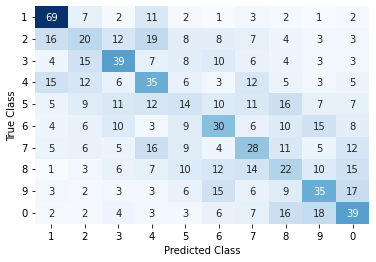

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

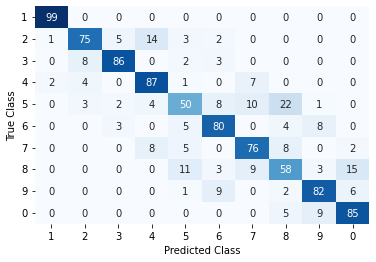

<IPython.core.display.Javascript object>

In [ ]:
# Plot the confusion matrix of one predictor for div=1 and div=10

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from google.colab import widgets

n_div = 10
n_seeds = 20
iDiv = [1, 10]

dataset = pd.read_csv('rf-prod.csv', header=None).values
#dataset = pd.read_csv('svm-prod.csv', header=None).values
#dataset = pd.read_csv('knn-sum.csv', header=None).values
#dataset = pd.read_csv('mlp-prod.csv', header=None).values

perf_all1 = []
perf_all2 = []
for iRow in range(len(dataset)):
    mat = np.reshape(dataset[iRow,:], (10, 10))
    mat = 100*mat / (mat[0].sum())
    if iRow % 2 == 0:
        perf_all1.append(mat)
    else:
        perf_all2.append(mat)

perf1 = [0] * n_div
for i in range(len(perf_all1)):
    perf1[i%n_div] = perf1[i%n_div] + perf_all1[i]    
perf1 = np.array(perf1) / n_seeds

tb = widgets.TabBar(['Div '+str(i) for i in iDiv])

for i in iDiv:
    with tb.output_to('Div '+str(i)):
        mat_cm = pd.DataFrame(np.round(perf1[i-1]), (1,2,3,4,5,6,7,8,9,0), (1,2,3,4,5,6,7,8,9,0))
        fig, ax = plt.subplots()
        sn.heatmap(mat_cm, annot=True, cbar=False, cmap='Blues')
        ax.set_ylabel('True Class')
        ax.set_xlabel('Predicted Class')
        plt.yticks(rotation=0)
        plt.savefig('knn-conf'+str(i)+'.pdf', bbox_inches='tight')

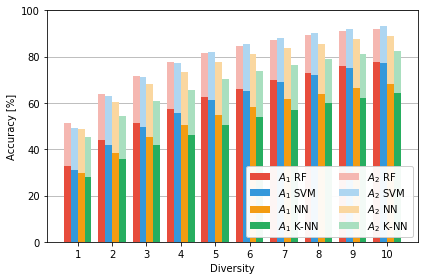

In [ ]:
# Plot accuracy of all predictors (1st and 2nd) for different diversity

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

n_div = 10
n_seeds = 20

fileNameMLP = 'mlp-prod.csv'
fileNameRF  = 'rf-prod.csv'
fileNameKNN = 'knn-sum.csv'
fileNameSVM = 'svm-prod.csv'

# RF
dataset = pd.read_csv(fileNameRF, header=None).values

perf_all_rf1 = []
perf_all_rf2 = []
for iRow in range(len(dataset)):
    mat = np.reshape(dataset[iRow,:], (10, 10))
    if iRow % 2 == 0:
        perf_all_rf1.append(100*np.trace(mat)/(mat[0].sum()*10))
    else:
        perf_all_rf2.append(100*np.trace(mat)/(mat[0].sum()*10))

perf_rf1 = [0] * n_div
perf_rf2 = [0] * n_div
for i in range(len(perf_all_rf1)):
    perf_rf1[i%n_div] = perf_rf1[i%n_div] + perf_all_rf1[i]    
    perf_rf2[i%n_div] = perf_rf2[i%n_div] + perf_all_rf2[i]
perf_rf1 = np.array(perf_rf1) / n_seeds
perf_rf2 = np.array(perf_rf2) / n_seeds

# SVM
dataset = pd.read_csv(fileNameSVM, header=None).values

perf_all_svm1 = []
perf_all_svm2 = []
for iRow in range(len(dataset)):
    mat = np.reshape(dataset[iRow,:], (10, 10))
    if iRow % 2 == 0:
        perf_all_svm1.append(100*np.trace(mat)/(mat[0].sum()*10))
    else:
        perf_all_svm2.append(100*np.trace(mat)/(mat[0].sum()*10))

perf_svm1 = [0] * n_div
perf_svm2 = [0] * n_div
for i in range(len(perf_all_svm1)):
    perf_svm1[i%n_div] = perf_svm1[i%n_div] + perf_all_svm1[i]    
    perf_svm2[i%n_div] = perf_svm2[i%n_div] + perf_all_svm2[i]
perf_svm1 = np.array(perf_svm1) / n_seeds
perf_svm2 = np.array(perf_svm2) / n_seeds

# MLP
dataset = pd.read_csv(fileNameMLP, header=None).values

perf_all_mlp1 = []
perf_all_mlp2 = []
for iRow in range(len(dataset)):
    mat = np.reshape(dataset[iRow,:], (10, 10))
    if iRow % 2 == 0:
        perf_all_mlp1.append(100*np.trace(mat)/(mat[0].sum()*10))
    else:
        perf_all_mlp2.append(100*np.trace(mat)/(mat[0].sum()*10))

perf_mlp1 = [0] * n_div
perf_mlp2 = [0] * n_div
for i in range(len(perf_all_mlp1)):
    perf_mlp1[i%n_div] = perf_mlp1[i%n_div] + perf_all_mlp1[i]    
    perf_mlp2[i%n_div] = perf_mlp2[i%n_div] + perf_all_mlp2[i]
perf_mlp1 = np.array(perf_mlp1) / n_seeds
perf_mlp2 = np.array(perf_mlp2) / n_seeds

# k-NN
dataset = pd.read_csv(fileNameKNN, header=None).values

perf_all_knn1 = []
perf_all_knn2 = []
for iRow in range(len(dataset)):
    mat = np.reshape(dataset[iRow,:], (10, 10))
    if iRow % 2 == 0:
        perf_all_knn1.append(100*np.trace(mat)/(mat[0].sum()*10))
    else:
        perf_all_knn2.append(100*np.trace(mat)/(mat[0].sum()*10))

perf_knn1 = [0] * n_div
perf_knn2 = [0] * n_div
for i in range(len(perf_all_knn1)):
    perf_knn1[i%n_div] = perf_knn1[i%n_div] + perf_all_knn1[i]    
    perf_knn2[i%n_div] = perf_knn2[i%n_div] + perf_all_knn2[i]
perf_knn1 = np.array(perf_knn1) / n_seeds
perf_knn2 = np.array(perf_knn2) / n_seeds

# Single digit plot
labels = list(range(1,n_div+1))
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars
fig, ax = plt.subplots()
ax.grid(axis='y', zorder=0)
rects1 = ax.bar(x - 3*width/2, perf_rf1 , width, label='$A_1$ RF', zorder=3, color = '#E74C3C')
rects3 = ax.bar(x - width/2  , perf_svm1, width, label='$A_1$ SVM', zorder=3, color = '#3498DB')
rects5 = ax.bar(x + width/2  , perf_mlp1, width, label='$A_1$ NN', zorder=3, color = '#F39C12')
rects7 = ax.bar(x + 3*width/2, perf_knn1, width, label='$A_1$ K-NN', zorder=3, color = '#27AE60')
rects2 = ax.bar(x - 3*width/2, perf_rf2 , width, bottom=perf_rf1, label='$A_2$ RF', zorder=3, color = '#F5B7B1')
rects4 = ax.bar(x - width/2  , perf_svm2, width, bottom=perf_svm1, label='$A_2$ SVM', zorder=3, color = '#AED6F1')
rects6 = ax.bar(x + width/2  , perf_mlp2, width, bottom=perf_mlp1, label='$A_2$ NN', zorder=3, color = '#FAD7A0')
rects8 = ax.bar(x + 3*width/2, perf_knn2, width, bottom=perf_knn1, label='$A_2$ K-NN', zorder=3, color = '#A9DFBF')

ax.set_xlabel('Diversity')
ax.set_ylabel('Accuracy [%]')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim((0, 100))
ax.legend(labelspacing=0.25, ncol=2, loc=4, framealpha=0.95)
fig.tight_layout()
plt.savefig('all-digit-acc.pdf', bbox_inches='tight')

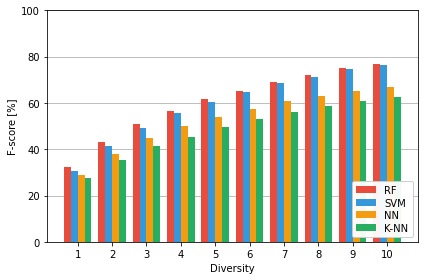

In [ ]:
# Plot F1-score of all predictors (1st and 2nd) for different diversity

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

n_div = 10
n_seeds = 20

fileNameMLP = 'mlp-prod.csv'
fileNameRF  = 'rf-prod.csv'
fileNameKNN = 'knn-sum.csv'
fileNameSVM = 'svm-prod.csv'

# RF
dataset = pd.read_csv(fileNameRF, header=None).values

perf_all_rf1 = []
perf_all_rf2 = []
for iRow in range(len(dataset)):
    mat = np.reshape(dataset[iRow,:], (10, 10))
    F1_k = []
    for ik in range(10):
        F1_k.append(2*mat[ik,ik] / (2*mat[ik,ik] + (np.sum(mat[:,ik])-mat[ik,ik]) + (np.sum(mat[ik,:])-mat[ik,ik])))
    if iRow % 2 == 0:
        perf_all_rf1.append(100*np.mean(F1_k))
    else:
        perf_all_rf2.append(100*np.mean(F1_k))

perf_rf1 = [0] * n_div
perf_rf2 = [0] * n_div
for i in range(len(perf_all_rf1)):
    perf_rf1[i%n_div] = perf_rf1[i%n_div] + perf_all_rf1[i]    
    perf_rf2[i%n_div] = perf_rf2[i%n_div] + perf_all_rf2[i]
perf_rf1 = np.array(perf_rf1) / n_seeds
perf_rf2 = np.array(perf_rf2) / n_seeds

# SVM
dataset = pd.read_csv(fileNameSVM, header=None).values

perf_all_svm1 = []
perf_all_svm2 = []
for iRow in range(len(dataset)):
    mat = np.reshape(dataset[iRow,:], (10, 10))
    F1_k = []
    for ik in range(10):
        F1_k.append(2*mat[ik,ik] / (2*mat[ik,ik] + (np.sum(mat[:,ik])-mat[ik,ik]) + (np.sum(mat[ik,:])-mat[ik,ik])))
    if iRow % 2 == 0:
        perf_all_svm1.append(100*np.mean(F1_k))
    else:
        perf_all_svm2.append(100*np.mean(F1_k))

perf_svm1 = [0] * n_div
perf_svm2 = [0] * n_div
for i in range(len(perf_all_svm1)):
    perf_svm1[i%n_div] = perf_svm1[i%n_div] + perf_all_svm1[i]    
    perf_svm2[i%n_div] = perf_svm2[i%n_div] + perf_all_svm2[i]
perf_svm1 = np.array(perf_svm1) / n_seeds
perf_svm2 = np.array(perf_svm2) / n_seeds

# MLP
dataset = pd.read_csv(fileNameMLP, header=None).values

perf_all_mlp1 = []
perf_all_mlp2 = []
for iRow in range(len(dataset)):
    mat = np.reshape(dataset[iRow,:], (10, 10))
    F1_k = []
    for ik in range(10):
        F1_k.append(2*mat[ik,ik] / (2*mat[ik,ik] + (np.sum(mat[:,ik])-mat[ik,ik]) + (np.sum(mat[ik,:])-mat[ik,ik])))
    if iRow % 2 == 0:
        perf_all_mlp1.append(100*np.mean(F1_k))
    else:
        perf_all_mlp2.append(100*np.mean(F1_k))

perf_mlp1 = [0] * n_div
perf_mlp2 = [0] * n_div
for i in range(len(perf_all_mlp1)):
    perf_mlp1[i%n_div] = perf_mlp1[i%n_div] + perf_all_mlp1[i]    
    perf_mlp2[i%n_div] = perf_mlp2[i%n_div] + perf_all_mlp2[i]
perf_mlp1 = np.array(perf_mlp1) / n_seeds
perf_mlp2 = np.array(perf_mlp2) / n_seeds

# k-NN
dataset = pd.read_csv(fileNameKNN, header=None).values

perf_all_knn1 = []
perf_all_knn2 = []
for iRow in range(len(dataset)):
    mat = np.reshape(dataset[iRow,:], (10, 10))
    F1_k = []
    for ik in range(10):
        F1_k.append(2*mat[ik,ik] / (2*mat[ik,ik] + (np.sum(mat[:,ik])-mat[ik,ik]) + (np.sum(mat[ik,:])-mat[ik,ik])))
    if iRow % 2 == 0:
        perf_all_knn1.append(100*np.mean(F1_k))
    else:
        perf_all_knn2.append(100*np.mean(F1_k))

perf_knn1 = [0] * n_div
perf_knn2 = [0] * n_div
for i in range(len(perf_all_knn1)):
    perf_knn1[i%n_div] = perf_knn1[i%n_div] + perf_all_knn1[i]    
    perf_knn2[i%n_div] = perf_knn2[i%n_div] + perf_all_knn2[i]
perf_knn1 = np.array(perf_knn1) / n_seeds
perf_knn2 = np.array(perf_knn2) / n_seeds

# Single digit plot
labels = list(range(1,n_div+1))
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars
fig, ax = plt.subplots()
ax.grid(axis='y', zorder=0)
rects1 = ax.bar(x - 3*width/2, perf_rf1 , width, label='RF', zorder=3, color = '#E74C3C')
rects3 = ax.bar(x - width/2  , perf_svm1, width, label='SVM', zorder=3, color = '#3498DB')
rects5 = ax.bar(x + width/2  , perf_mlp1, width, label='NN', zorder=3, color = '#F39C12')
rects7 = ax.bar(x + 3*width/2, perf_knn1, width, label='K-NN', zorder=3, color = '#27AE60')

ax.set_xlabel('Diversity')
ax.set_ylabel('F-score [%]')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim((0, 100))
ax.legend(labelspacing=0.25, ncol=1, loc=4, framealpha=0.95)
fig.tight_layout()
plt.savefig('all-digit-F.pdf', bbox_inches='tight')